In [1]:
import sys

sys.path.insert(1, '/Users/users/spirov/ThesisProject/Executable')

import numpy as np
import torch
from torch.utils.data import DataLoader
from torch import nn
from NeuralNets import CustomVaexDataset, printNodes, sc, StraightNetwork,Unet,Stefann
from matplotlib import pyplot as plt

from torch.nn.modules.loss import _Loss



from DataCore import snapshotPath,L


from cycler import cycler


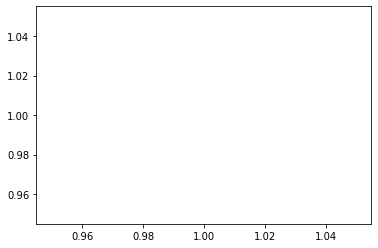

In [2]:


plt.plot([1],[1])

font = {"weight": "normal", "size": 14}
plt.rcParams["axes.linewidth"] = 1.5  # set the value globally
plt.rc("font", **font)
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
_legend = {"frameon": True, "framealpha":0.7}
plt.rc("legend", **_legend)
plt.rcParams["axes.prop_cycle"] = cycler("color",('indigo','b','r','k','#ff7f0e','g'))
plt.show()

# Model Maker

In [3]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)[0]
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 4 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: [{current:>5d}/{size:>5d}]  {loss:>7f}")

            
            
            
def snapshot(name=""):
    print("------------------")
    print("Autosave...")
    print("------------------")
    torch.save(model.state_dict(), snapshotPath)
    fig= plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.ylim(52,54)
    plt.plot(Ls, marker="+")
    plt.title("Loss")
    plt.subplot(122)
    plt.plot(Cs, marker="v")
    plt.title("Correctness")
    plt.suptitle(f"Snapshot {name}")
    fig.savefig('./Model Figures/Model State.png', dpi=fig.dpi)


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)[0]
            test_loss += loss_fn(pred, y).item()
            correct += ((pred - y).abs() < bmark).type(torch.float).sum().item()

    test_loss /= num_batches

    correct /= size * y.size()[1]
    print(f"Test Error: \n Accuracy: {(100 * correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    Ls.append(test_loss)
    Cs.append(correct)



In [4]:

batch_size = 64

p2 = "/Users/users/spirov/Blk/Nexus Project/Thesis-Project-Cosmic-Web/Data/Training/"
p3 = "/Users/users/spirov/Blk/Nexus Project/Thesis-Project-Cosmic-Web/Data/Testing/"


train_set = CustomVaexDataset(p2)
test_set = CustomVaexDataset(p3)


torch.set_default_dtype(torch.float64)

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print("----------------------")
print(f"Using {device} device")
print("----------------------")




printNodes()



train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=True)





----------------------
Using cpu device
----------------------
----------------
33600 -> 8192 -> 11200
----------------


In [5]:
def scatterLossPrototype(output,target):
    loss1 = torch.mean((output - target)**2)
    tstd = target.std().item()
    ostd = output.std().item()
    
    loss2 = (tstd/ostd + ostd/tstd)/2 - 1
    
    loss = loss1 + loss2*3
    
    return loss

def bigLSE(output,target):
    
    p = 3
    
    loss = torch.mean(((output-target)**2)**p)
    
    return loss
    

def inverseXLSE(out,tar):
    
    x = (tar.max()/tar)**2
    
    p = 0.25
    
    loss = torch.mean(((out-tar)**2)*x*p)
    
    return loss
    
    
def ratioLoss(out,tar):
    
    outSafe = out + 1e-3
    
    l = outSafe/tar + tar/outSafe
    
    loss = l.abs().sum()
    
    return loss
    
    
    

    
    

In [6]:
learning_rate = 1e-2 #sc/1e5
epochs = 40
bmark = 1e3/sc


In [93]:
GoodPath = "/Users/users/spirov/ThesisProject/Snapshots/NewGoodSnap.pt"

model =StraightNetwork() #BottleneckNetwork() # StraightNetwork() #
model.load_state_dict(torch.load(GoodPath))

dataPath = "/Users/users/spirov/Blk/Nexus Project/Thesis-Project-Cosmic-Web/Data/Testing/"

dataset = CustomVaexDataset(dataPath)

img, label = dataset.__getitem__(0)

with torch.no_grad():
    mod = model(img.reshape(1,3,len(label)))





In [94]:
mod[0].shape

torch.Size([11200])

Text(0, 0.5, 'residual')

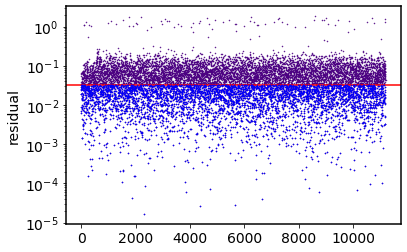

In [95]:
resid = (mod[0]-label).abs()

plt.plot(resid,marker='.',linestyle='',markersize=1)

plt.axhline(1e3/sc,c='r')

filt = resid<(1e3/sc)

plt.plot(np.arange(resid.size()[0])[filt],resid[filt],marker='.',linestyle='',markersize=1)

plt.yscale('log')
plt.ylabel("residual")


### 

Text(0.5, 0, 'residual')

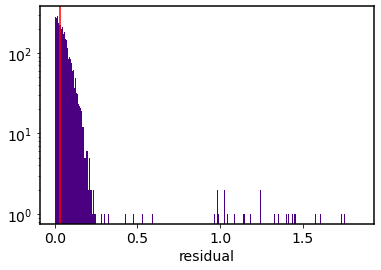

In [96]:
plt.hist(resid,1000)
plt.yscale('log')
plt.axvline(1e3/sc,c='r')
plt.xlabel('residual')

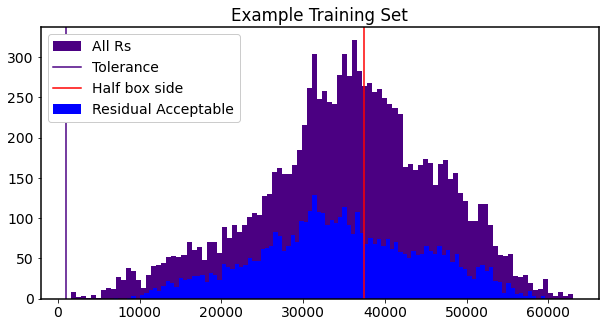

In [59]:
plt.figure(figsize=(10,5))
plt.hist(label*sc,100,label='All Rs')
plt.axvline(1e3,label='Tolerance')
plt.axvline(3.75e4,c='r',label="Half box side")
plt.hist(label[filt]*sc,100,label='Residual Acceptable')

plt.legend(loc=2,framealpha=1)
plt.title("Example Training Set")
plt.show()

In [72]:
trus = label[filt].size()[0]
tot = label.size()[0]


print(trus/tot)

0.415625


In [80]:
mod[0]

tensor([0.9459, 0.9106, 0.7711,  ..., 1.0761, 1.0110, 1.8659])

In [90]:
loss_fn = nn.MSELoss()

In [92]:
loss_fn(mod[0],label)

tensor(0.0142)

In [91]:
loss_fn(mod,label)

tensor(0.0142)

In [ ]:
with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)[0]
            test_loss += loss_fn(pred, y).item()
            correct += ((pred - y).abs() < bmark).type(torch.float).sum().item()

    test_loss /= num_batches


In [81]:
label

tensor([0.8714, 0.8399, 0.8587,  ..., 1.0289, 1.0391, 1.8443])

# Making a new one

Epoch 1
-------------------------------
loss: [   64/ 1536]  0.391004
loss: [  320/ 1536]  0.390989
loss: [  576/ 1536]  0.390952
loss: [  832/ 1536]  0.390937
loss: [ 1088/ 1536]  0.391002
loss: [ 1344/ 1536]  0.390852
Test Error: 
 Accuracy: 0.2%, Avg loss: 0.390737 

plotting


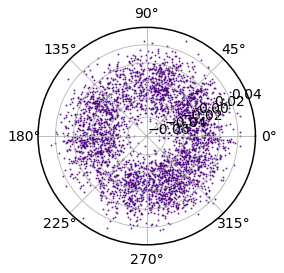

Epoch 2
-------------------------------
loss: [   64/ 1536]  0.390861
loss: [  320/ 1536]  0.390817
loss: [  576/ 1536]  0.390755
loss: [  832/ 1536]  0.390821
loss: [ 1088/ 1536]  0.390747
loss: [ 1344/ 1536]  0.390679
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.390559 

plotting


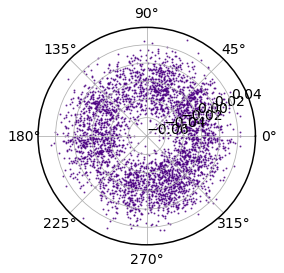

Epoch 3
-------------------------------
loss: [   64/ 1536]  0.390626
loss: [  320/ 1536]  0.390637
loss: [  576/ 1536]  0.390580
loss: [  832/ 1536]  0.390603
loss: [ 1088/ 1536]  0.390551
loss: [ 1344/ 1536]  0.390456
Test Error: 
 Accuracy: 0.2%, Avg loss: 0.390381 

plotting


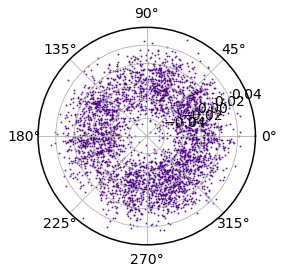

Epoch 4
-------------------------------
loss: [   64/ 1536]  0.390424
loss: [  320/ 1536]  0.390364
loss: [  576/ 1536]  0.390472
loss: [  832/ 1536]  0.390333
loss: [ 1088/ 1536]  0.390361
loss: [ 1344/ 1536]  0.390318
Test Error: 
 Accuracy: 0.2%, Avg loss: 0.390202 

plotting


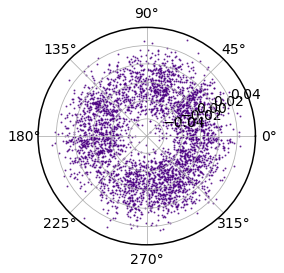

Epoch 5
-------------------------------
loss: [   64/ 1536]  0.390262
loss: [  320/ 1536]  0.390229
loss: [  576/ 1536]  0.390243
loss: [  832/ 1536]  0.390204
loss: [ 1088/ 1536]  0.390205
loss: [ 1344/ 1536]  0.390180
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.390025 

plotting


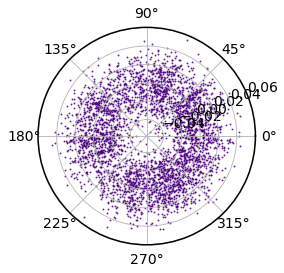

Epoch 6
-------------------------------
loss: [   64/ 1536]  0.390096
loss: [  320/ 1536]  0.390083
loss: [  576/ 1536]  0.390016
loss: [  832/ 1536]  0.389962
loss: [ 1088/ 1536]  0.389962
loss: [ 1344/ 1536]  0.389935
Test Error: 
 Accuracy: 0.2%, Avg loss: 0.389845 

plotting


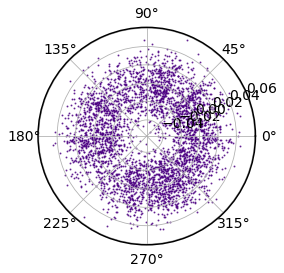

Epoch 7
-------------------------------
loss: [   64/ 1536]  0.389928
loss: [  320/ 1536]  0.389899
loss: [  576/ 1536]  0.389846
loss: [  832/ 1536]  0.389826
loss: [ 1088/ 1536]  0.389800
loss: [ 1344/ 1536]  0.389781
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.389663 

plotting


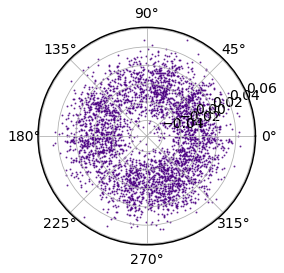

Epoch 8
-------------------------------
loss: [   64/ 1536]  0.389712
loss: [  320/ 1536]  0.389703
loss: [  576/ 1536]  0.389681
loss: [  832/ 1536]  0.389664
loss: [ 1088/ 1536]  0.389536
loss: [ 1344/ 1536]  0.389591
Test Error: 
 Accuracy: 0.2%, Avg loss: 0.389481 

plotting


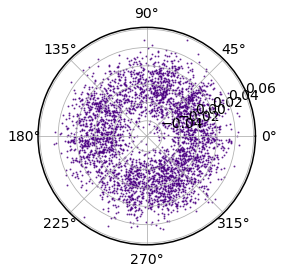

Epoch 9
-------------------------------
loss: [   64/ 1536]  0.389532
loss: [  320/ 1536]  0.389456
loss: [  576/ 1536]  0.389507
loss: [  832/ 1536]  0.389517
loss: [ 1088/ 1536]  0.389412
loss: [ 1344/ 1536]  0.389417
Test Error: 
 Accuracy: 0.2%, Avg loss: 0.389295 

plotting


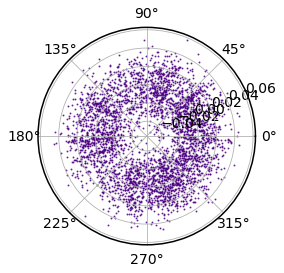

Epoch 10
-------------------------------
loss: [   64/ 1536]  0.389340
loss: [  320/ 1536]  0.389327
loss: [  576/ 1536]  0.389274
loss: [  832/ 1536]  0.389243
loss: [ 1088/ 1536]  0.389285
loss: [ 1344/ 1536]  0.389248
Test Error: 
 Accuracy: 0.2%, Avg loss: 0.389106 

plotting


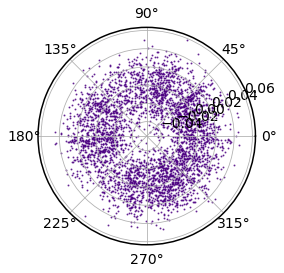

Epoch 11
-------------------------------
loss: [   64/ 1536]  0.389131
loss: [  320/ 1536]  0.389075
loss: [  576/ 1536]  0.389126
loss: [  832/ 1536]  0.388993
loss: [ 1088/ 1536]  0.389103
loss: [ 1344/ 1536]  0.388975
Test Error: 
 Accuracy: 0.2%, Avg loss: 0.388911 

plotting


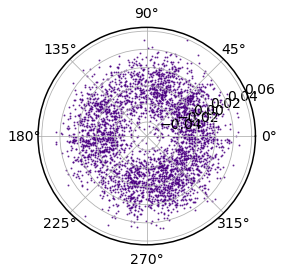

Epoch 12
-------------------------------
loss: [   64/ 1536]  0.389025
loss: [  320/ 1536]  0.388937
loss: [  576/ 1536]  0.388872
loss: [  832/ 1536]  0.388822
loss: [ 1088/ 1536]  0.388859
loss: [ 1344/ 1536]  0.388886
Test Error: 
 Accuracy: 0.2%, Avg loss: 0.388716 

plotting


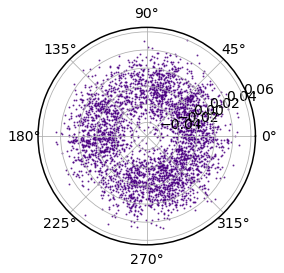

Epoch 13
-------------------------------
loss: [   64/ 1536]  0.388742
loss: [  320/ 1536]  0.388670
loss: [  576/ 1536]  0.388702
loss: [  832/ 1536]  0.388651
loss: [ 1088/ 1536]  0.388699
loss: [ 1344/ 1536]  0.388569
Test Error: 
 Accuracy: 0.2%, Avg loss: 0.388513 

plotting


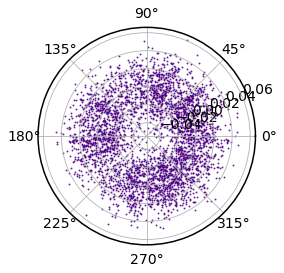

Epoch 14
-------------------------------
loss: [   64/ 1536]  0.388497
loss: [  320/ 1536]  0.388499
loss: [  576/ 1536]  0.388520
loss: [  832/ 1536]  0.388435
loss: [ 1088/ 1536]  0.388447
loss: [ 1344/ 1536]  0.388370
Test Error: 
 Accuracy: 0.2%, Avg loss: 0.388301 

plotting


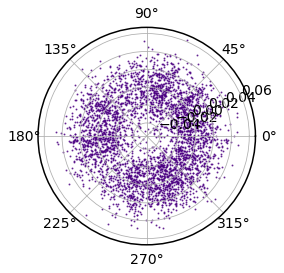

Epoch 15
-------------------------------
loss: [   64/ 1536]  0.388367
loss: [  320/ 1536]  0.388307
loss: [  576/ 1536]  0.388266
loss: [  832/ 1536]  0.388156
loss: [ 1088/ 1536]  0.388243
loss: [ 1344/ 1536]  0.388145
Test Error: 
 Accuracy: 0.2%, Avg loss: 0.388086 

plotting


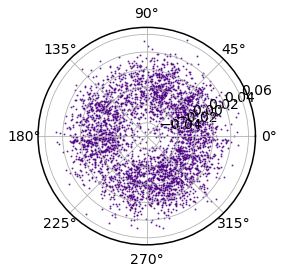

Epoch 16
-------------------------------
loss: [   64/ 1536]  0.388127
loss: [  320/ 1536]  0.388077
loss: [  576/ 1536]  0.388103
loss: [  832/ 1536]  0.387929
loss: [ 1088/ 1536]  0.388015
loss: [ 1344/ 1536]  0.388006
Test Error: 
 Accuracy: 0.2%, Avg loss: 0.387861 

plotting


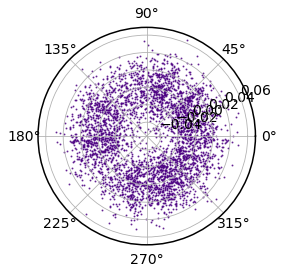

Epoch 17
-------------------------------
loss: [   64/ 1536]  0.387879
loss: [  320/ 1536]  0.387871
loss: [  576/ 1536]  0.387822
loss: [  832/ 1536]  0.387814
loss: [ 1088/ 1536]  0.387739
loss: [ 1344/ 1536]  0.387689
Test Error: 
 Accuracy: 0.2%, Avg loss: 0.387627 

plotting


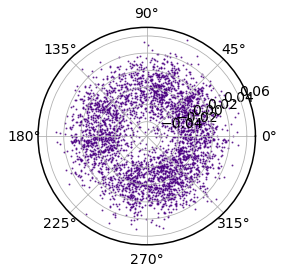

Epoch 18
-------------------------------
loss: [   64/ 1536]  0.387620
loss: [  320/ 1536]  0.387639
loss: [  576/ 1536]  0.387522
loss: [  832/ 1536]  0.387481
loss: [ 1088/ 1536]  0.387520
loss: [ 1344/ 1536]  0.387444
Test Error: 
 Accuracy: 0.3%, Avg loss: 0.387381 

plotting


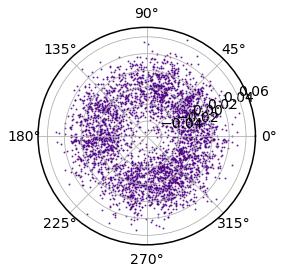

Epoch 19
-------------------------------
loss: [   64/ 1536]  0.387378
loss: [  320/ 1536]  0.387350
loss: [  576/ 1536]  0.387332
loss: [  832/ 1536]  0.387281
loss: [ 1088/ 1536]  0.387232
loss: [ 1344/ 1536]  0.387247
Test Error: 
 Accuracy: 0.2%, Avg loss: 0.387124 

plotting


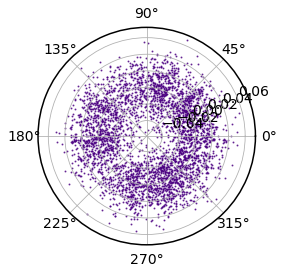

Epoch 20
-------------------------------
loss: [   64/ 1536]  0.387073
loss: [  320/ 1536]  0.387108
loss: [  576/ 1536]  0.387015
loss: [  832/ 1536]  0.386955
loss: [ 1088/ 1536]  0.386956
loss: [ 1344/ 1536]  0.386981
Test Error: 
 Accuracy: 0.2%, Avg loss: 0.386852 

plotting


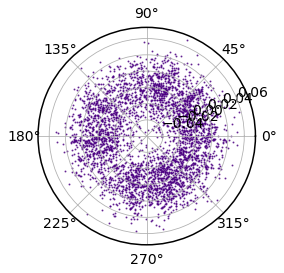

Epoch 21
-------------------------------
loss: [   64/ 1536]  0.386828
loss: [  320/ 1536]  0.386772
loss: [  576/ 1536]  0.386862
loss: [  832/ 1536]  0.386667
loss: [ 1088/ 1536]  0.386755
loss: [ 1344/ 1536]  0.386534
Test Error: 
 Accuracy: 0.2%, Avg loss: 0.386564 

plotting


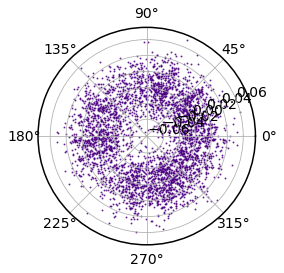

Epoch 22
-------------------------------
loss: [   64/ 1536]  0.386546
loss: [  320/ 1536]  0.386572
loss: [  576/ 1536]  0.386401
loss: [  832/ 1536]  0.386431
loss: [ 1088/ 1536]  0.386406
loss: [ 1344/ 1536]  0.386324
Test Error: 
 Accuracy: 0.2%, Avg loss: 0.386257 

plotting


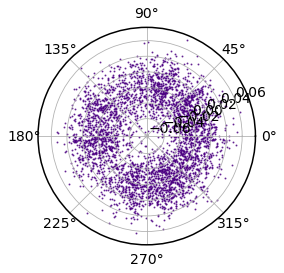

Epoch 23
-------------------------------
loss: [   64/ 1536]  0.386381
loss: [  320/ 1536]  0.386153
loss: [  576/ 1536]  0.386119
loss: [  832/ 1536]  0.386095
loss: [ 1088/ 1536]  0.385991
loss: [ 1344/ 1536]  0.386003
Test Error: 
 Accuracy: 0.2%, Avg loss: 0.385930 

plotting


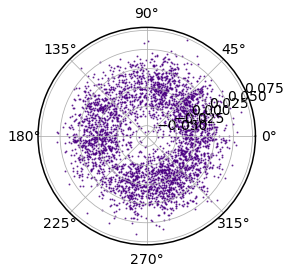

Epoch 24
-------------------------------
loss: [   64/ 1536]  0.385894
loss: [  320/ 1536]  0.385881
loss: [  576/ 1536]  0.385837
loss: [  832/ 1536]  0.385765
loss: [ 1088/ 1536]  0.385706
loss: [ 1344/ 1536]  0.385568
Test Error: 
 Accuracy: 0.2%, Avg loss: 0.385577 

plotting


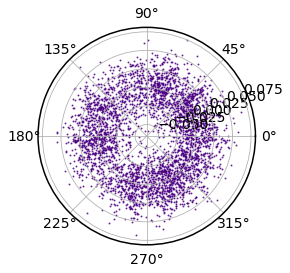

Epoch 25
-------------------------------
loss: [   64/ 1536]  0.385581
loss: [  320/ 1536]  0.385447
loss: [  576/ 1536]  0.385520
loss: [  832/ 1536]  0.385305
loss: [ 1088/ 1536]  0.385384
loss: [ 1344/ 1536]  0.385316
Test Error: 
 Accuracy: 0.1%, Avg loss: 0.385199 

plotting


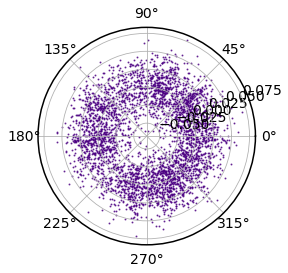

Epoch 26
-------------------------------
loss: [   64/ 1536]  0.385204
loss: [  320/ 1536]  0.385144
loss: [  576/ 1536]  0.385028
loss: [  832/ 1536]  0.384854
loss: [ 1088/ 1536]  0.384950
loss: [ 1344/ 1536]  0.384724
Test Error: 
 Accuracy: 0.2%, Avg loss: 0.384786 

plotting


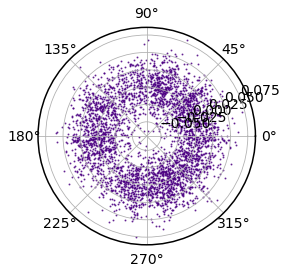

Epoch 27
-------------------------------
loss: [   64/ 1536]  0.384791
loss: [  320/ 1536]  0.384712
loss: [  576/ 1536]  0.384644
loss: [  832/ 1536]  0.384553
loss: [ 1088/ 1536]  0.384509
loss: [ 1344/ 1536]  0.384423
Test Error: 
 Accuracy: 0.2%, Avg loss: 0.384337 

plotting


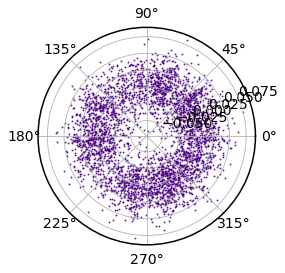

Epoch 28
-------------------------------
loss: [   64/ 1536]  0.384330
loss: [  320/ 1536]  0.384197
loss: [  576/ 1536]  0.384137


In [ ]:
img, label = test_set.__getitem__(0)
plotscale = 10

ran = L/2
ran /= sc



Ls = []
Cs = []


loss_fn = inverseXLSE#ratioLoss#Stefann(10)#nn.MSELoss() 

    #CrossEntropyLoss HuberLoss

model = StraightNetwork()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) 


#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9) 
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,20], gamma=.1)

for t in [0]#range(epochs):
       
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
 #   scheduler.step()
    with torch.no_grad():
        mod = model(img.reshape(1,3,len(label)))
    
    print('plotting')
    plt.subplot(projection="polar")
    plt.scatter(img[2],mod,s=0.1*plotscale,alpha=0.7)
    plt.show()
    
print("Done!")



# Model Tester

In [ ]:

dataset = CustomVaexDataset(p3)

img, label = dataset.__getitem__(0)


with torch.no_grad():
    mod = model(img.reshape(1,3,len(label)))
    


In [ ]:
fig= plt.figure(figsize=(10,6))
plt.subplot(121)
#plt.ylim(52,54)
plt.plot(Ls, marker="+")
plt.title("Loss")
plt.subplot(122)
plt.plot(Cs, marker="v")
plt.title("Correctness")
plt.show()

In [ ]:
plotscale = 10

ran = L/2
ran /= sc

fig = plt.figure(figsize=(30,10))
plt.subplot(131,projection="polar")
plt.scatter(img[2],img[0],s=0.1*plotscale,alpha=0.7)
plt.ylim(0,ran)
plt.title("Broken")

plt.subplot(132,projection="polar")
plt.scatter(img[2],mod,s=0.1*plotscale,alpha=0.7)
plt.title("Model")
plt.ylim(min([mod.min(),0]),ran)

plt.subplot(133,projection="polar")
plt.scatter(img[2],label,s=0.1*plotscale,alpha=0.7)
plt.title("Correct")
plt.ylim(0,ran)

plt.suptitle("Data loaded from set")
plt.show()

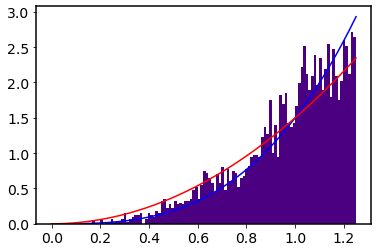

In [18]:
plt.hist(label,100,density=True)
x = np.linspace(0,1.25,50)
plt.plot(x,1.5*x**3)
plt.plot(x,1.5*x**2)

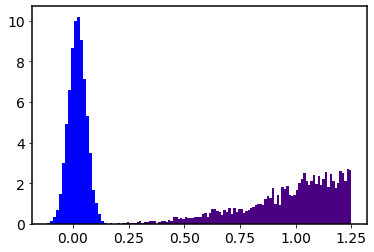

In [13]:
plt.hist(label,100,density=True)
plt.hist(mod,20,density=True)
plt.show()

In [14]:
mod.std()/label.std() + label.std()/mod.std()

tensor(5.6766)

In [ ]:
plt.plot(mod[0],marker='.',linestyle = '')
plt.plot(label,marker='.',linestyle = '')
plt.show()



dat = (label.max()/label)*((mod-label)**2)

mo = mod[0] + 1e-3
dat = (mo/label + label/mo).abs()


plt.plot(dat,marker='.',linestyle = '')



In [ ]:
plt.hist(dat,20)
plt.show()

In [ ]:
torch.mean(dat)

In [ ]:
tester = lambda x: x.diff().abs().sum().item()
test = lambda x: x.std().item()

In [ ]:
test(mod)

In [ ]:
test(label)

In [ ]:
ls = tester(label)#label.std().item()
print(ls)

In [ ]:
ms = tester(mod)#mod.std().item()
print(ms)

In [ ]:
l = (ms/ls + ls/ms)/2

In [ ]:
l*5*1e-2

Exp:

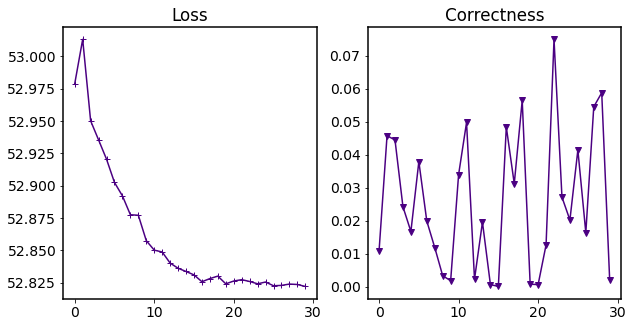




Nothing

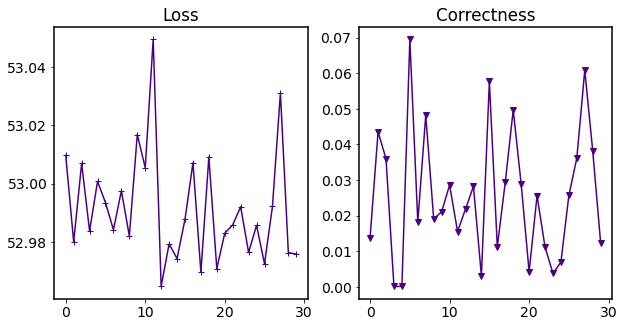